In [46]:
import numpy as np
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson #essa biblioteca importa GLM - modelos lineares generalizados
from statsmodels.genmod.families.links import identity, log
from scipy.stats import chi2
from statsmodels.distributions.empirical_distribution import ECDF
from pandas import DataFrame as df
from scipy.io import loadmat
from matplotlib.pyplot import plot, xlabel, ylabel, show
from matplotlib import rcParams
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = (12,3)

- Spikes de um neurônio do hipocampo
- Experimento: animal em uma tarefa em um labirinto e analisar atividade de place cells
- placecell - neuronio que sempre tem atividade quando o animal esta em determinado lugar ou fazendo certa atividade

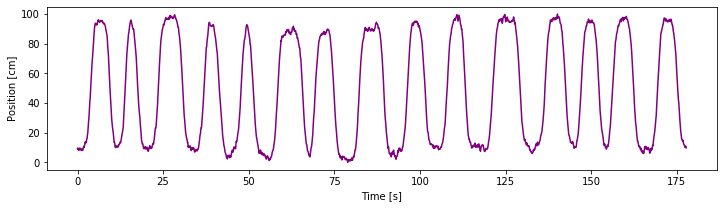

In [47]:
#Análise Visual

#Variáveis:
#x: posição do rato em centímetros
#t: tempo
#spiketimes: tempo de ocorrência dos spikes


data = loadmat('Aula13-spikes-1.mat')  
t = data['t'][:,0] 
X = data['X'][:,0] 
plot(t, X, color = "purple")
xlabel('Time [s]')
ylabel('Position [cm]')
show()


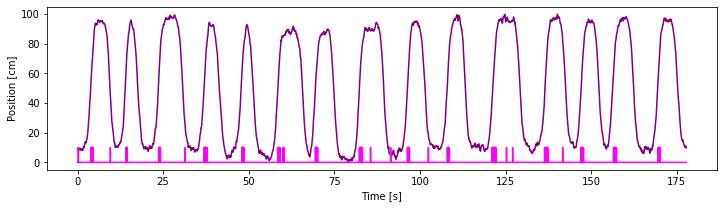

In [48]:
spiketimes = data['spiketimes']
n_bins = len(t)
spiketrain = np.histogram(spiketimes,
                     	bins = n_bins,
                     	range = (t[0], t[-1]))[0]

plot(t, X, color = "purple") 
plot(t, 10 * spiketrain, color = "fuchsia") 
plt.xlabel('Time [s]')
plt.ylabel('Position [cm]')
show()


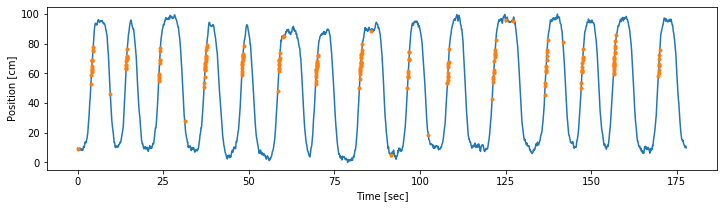

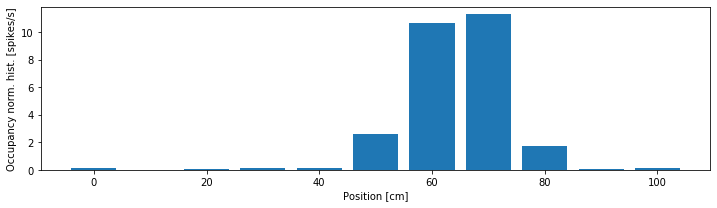

In [49]:
spikeindex = np.where(spiketrain!=0)[0] 
plot(t, X)                           
plot(t[spikeindex], X[spikeindex], '.')
xlabel('Time [sec]')            
ylabel('Position [cm]')
show()

bin_edges = np.arange(-5, 106, 10)                 
spikehist = np.histogram(X[spikeindex], bin_edges)[0] 
occupancy = np.histogram(X, bin_edges)[0]*0.001       
plt.bar(np.linspace(0, 100, 11), spikehist/occupancy, width=8) 
xlabel('Position [cm]')                 
ylabel('Occupancy norm. hist. [spikes/s]')
show()

#Sempre que o rato está na faixa de 60 a 80, há disparo do sinal

#no histograma é plotado a posição pela taxa de disparo


In [52]:
#modelo 1

predictors = df(data={'Intercept': np.ones_like(X), 'X': X})
model1 = sm.GLM(spiketrain, predictors, family=Poisson(identity()))
model1_results = model1.fit() 
b1 = model1_results.params
print('b1:')
print(b1)

 

/home/aluno/.local/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:273: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  DomainWarning)


b1:
Intercept   -0.000097
X            0.000027
dtype: float64


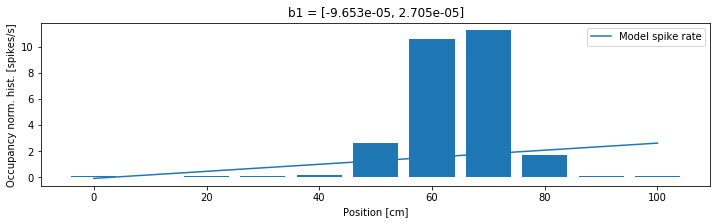

In [53]:
bins = np.linspace(0, 100, 11)
plt.bar(bins, spikehist/occupancy, width=8)	
plot(bins,(b1[0]+b1[1]*bins)*1000,
 	label="Model spike rate")     	
xlabel('Position [cm]')                	
ylabel('Occupancy norm. hist. [spikes/s]')
plt.title("b1 = [{0[0]:.4}, {0[1]:.4}]".format(b1))
plt.legend()
show()


In [72]:
#modelo 2

model2 = sm.GLM(spiketrain, predictors, family=Poisson(log())) 
model2_results = model2.fit() 
b2 = model2_results.params

model2 = sm.GLM(spiketrain, predictors, family=Poisson())  
model2_results = model2.fit()  
b2 = model2_results.params  
print(b2)


Intercept   -7.438887
X            0.012943
dtype: float64


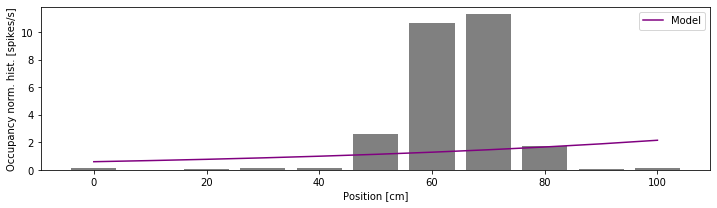

In [73]:
plt.bar(bins, spikehist/occupancy, width=8, color = "grey")	
plot(bins, np.exp(b2[0] + b2[1] * bins) * 1000,
 	'k', label='Model', color = "purple")   
xlabel('Position [cm]')                    	
ylabel('Occupancy norm. hist. [spikes/s]')
plt.legend()
show()


In [75]:
#modelo 3

predictors['X2'] = X**2 

model3 = sm.GLM(spiketrain, predictors, family=Poisson())
model3_results = model3.fit() 
b3 = model3_results.params 
print('b3:\n', b3)



b3:
 Intercept   -26.279057
X             0.690114
X2           -0.005463
dtype: float64


In [78]:
#Interpretendo o modelo 3

mu = -b3[1] / (2 * b3[2])                  
sigma = np.sqrt(-1 / (2 * b3[2]))             
alpha = np.exp(b3[0] - b3[1]**2 / 4 / b3[2])  

print('mu: {}\nsigma: {}\nalpha: {}'.format(mu, sigma, alpha))

mu: 63.16295780404583
sigma: 9.566890841873288
alpha: 0.01128549519918389


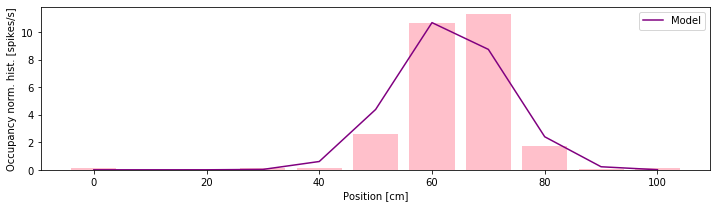

In [85]:
plt.bar(bins, spikehist / occupancy, width=8, color = "pink")
plot(bins, np.exp(b3[0] + b3[1] * bins + b3[2] * bins**2) * 1000,  label='Model', color = "purple")
xlabel('Position [cm]')                	
ylabel('Occupancy norm. hist. [spikes/s]')
plt.legend()
show()


In [88]:
#AIC = resume o quão bom um modelo é. Qto mais parametros tiver, melhor será. desvantagem = seu modelo acaba adquirindo alguns ruídos

LL2 = model2.loglike(b2)
AIC2 = -2 * LL2 + 2 * 2
print('AIC2: ', AIC2)
print('model2_results.aic: ', model2_results.aic)


LL3 = model3.loglike(b3)
AIC3 = -2 * LL3 + 2 * 3
print('AIC3: ', AIC3)

AIC2:  3344.7908629386066
model2_results.aic:  3344.7908629386066
AIC3:  2708.776362292047


In [93]:
#Intervalo de Confiança

CI2 = np.array([b2 - 2 * model2_results.bse, b2 + 2 * model2_results.bse]) 
print('CI2:\n', CI2)

eCI2 = np.exp(CI2)
print(eCI2)

CI2:
 [[-7.73444907  0.00892032]
 [-7.14332531  0.01696651]]
[[4.37493342e-04 1.00896023e+00]
 [7.90120328e-04 1.01711126e+00]]


In [94]:
CI3 = np.array([b3 - 2 * model3_results.bse,
        	b3 + 2 * model3_results.bse]) 
print(CI3)

p_beta2 = model3_results.pvalues[2]
print(p_beta2)

[[-2.99542831e+01  5.77810706e-01 -6.30948487e-03]
 [-2.26038307e+01  8.02417242e-01 -4.61644384e-03]]
4.1170804306785067e-38


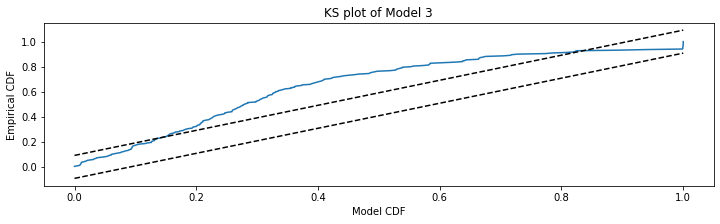

In [101]:
#KS Test

lambda3 = np.exp(b3[0] + b3[1] * X + b3[2] * X**2)  	
Z = [sum(lambda3[a:b])                           	
 	for a, b, in zip(np.hstack((0, spikeindex[:-1])), spikeindex)]

ecdf = ECDF(Z)
mCDF = 1 - np.exp(-ecdf.x)
N = len(Z)

plot(mCDF, ecdf.y)
plot([0,1], [0,1] + 1.36/np.sqrt(N),'k--', ms = 2)
plot([0,1], [0,1] - 1.36/np.sqrt(N),'k--', ms = 2)
xlabel('Model CDF')             
ylabel('Empirical CDF')
plt.title('KS plot of Model 3')
show()


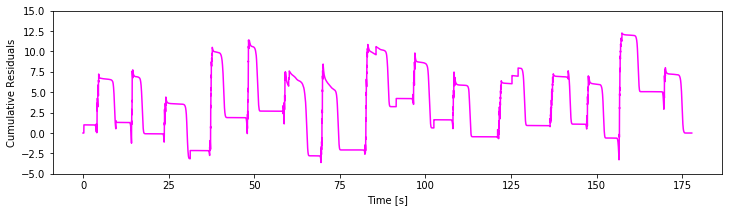

In [106]:
#Análise Residual
#mostra que alguma coisa ainda não foi modelada na equação

R = np.cumsum(model3_results.resid_response)


plot(t, R, color = "fuchsia")
plt.ylim(-5, 15)
xlabel('Time [s]')
ylabel('Cumulative Residuals')
show()


In [111]:
increasing = np.where(np.diff(X.flatten()) > 0)[0]  
direction = np.zeros_like(X) 
direction[increasing] = 1

predictors['direction'] = direction 

model4 = sm.GLM(spiketrain, predictors, family=Poisson())
model4_results = model4.fit() 
b4 = model4_results.params
print(b4)


Intercept   -28.870275
X             0.688905
X2           -0.005452
direction     3.275282
dtype: float64


In [113]:
dev4 = model4_results.deviance
dev3 = model3_results.deviance
dAIC = (dev3 + 2 * 3) - (dev4 + 2 * 4) 
print(dAIC)

233.86944739331148


CI_beta3 = [b4[3] - 2*model4_results.bse[3], b4[3] + 2*model4_results.bse[3]]
p_beta3 = model4_results.pvalues[3]  
print('CI_beta3: ', CI_beta3)
print('p_beta3: ', p_beta3)
 


233.86944739331102
CI_beta3:  [2.5549560544170626, 3.9956073965371566]
p_beta3:  9.555627447238077e-20


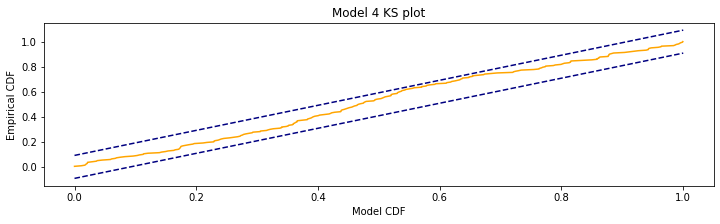

In [126]:
lambda4 = np.exp(b4[0] + b4[1]*X + b4[2]*X**2 + b4[3]*direction)

Z = [sum(lambda4[a:b]) 
 	for a, b in zip(np.hstack((0, spikeindex[:-1])), spikeindex)]  

ecdf = ECDF(Z)                               	
mCDF = 1 - np.exp(-ecdf.x)                      	

plot(mCDF, ecdf.y, color = "orange")                           	
plot([0,1], [0,1]+1.36/np.sqrt(N),'k--', ms = 2, color = "navy")	
plot([0,1], [0,1]-1.36/np.sqrt(N),'k--', ms = 2, color = "navy")	
xlabel('Model CDF')                          	
ylabel('Empirical CDF')
plt.title('Model 4 KS plot')
show()


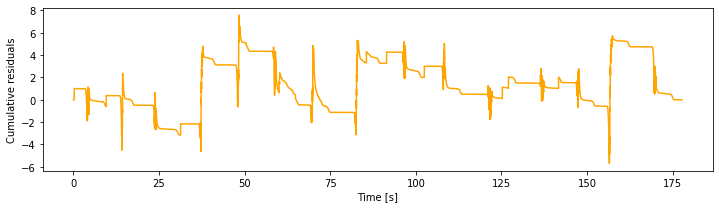

In [124]:
R = np.cumsum(model4_results.resid_response)  
plot(t,R, color = "orange")                              	
xlabel('Time [s]')
ylabel('Cumulative residuals')
show()


In [129]:
mu = -b4[1] / (2 * b4[2])             	
sigma = np.sqrt(-1 / (2 * b4[2]))        	
alpha = np.exp(b4[0] - b4[1]**2 / (4 * b4[2]))  

print('mu: ', mu)
print('sigma: ', sigma)
print('alpha: ', alpha)


mu:  63.18440082980685
sigma:  9.576905113790795
alpha:  0.0008199709288924232


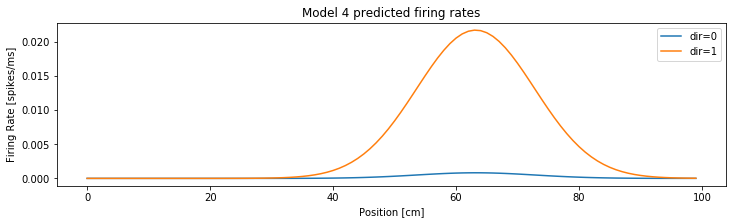

In [137]:
xs = np.arange(100)

dir_0 = np.array([np.ones_like(xs), xs, xs**2, np.zeros_like(xs)]).T 
dir_1 = np.array([np.ones_like(xs), xs, xs**2, np.ones_like(xs)]).T  
lambda4_0 = model4_results.predict(dir_0)  
lambda4_1 = model4_results.predict(dir_1)  

plot(xs, lambda4_0, label="dir=0")  
plot(xs, lambda4_1, label="dir=1")
xlabel('Position [cm]')
ylabel('Firing Rate [spikes/ms]')
plt.title('Model 4 predicted firing rates')
plt.legend()
show()
